In [1]:
import os
import sys
# sys.path.insert(0, '/tf')
import importlib

gpu_num = "0" # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
# import sionna
# importlib.reload(sionna)


In [2]:
import sys
sys.path

['/tf/custom',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages']

In [ ]:

import sys
sys.path.append("..")
import sionna

# import pdb
# pdb.set_trace()

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, channel_capacity, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement


In [2]:
sionna.__file__

'/tf/custom/../sionna/__init__.py'

In [12]:
# Load the scene
scene = load_scene("test_scenes/hallway/hallway.xml")

print(f'size:{scene.size}' )
print(f'center:{scene.center}')


scene.remove("tx")
scene.remove("rx")
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-4,0,2.5])

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[3,0,2.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

# Assign Radio material
scene.get("elm__3").radio_material.scattering_coefficient = 0.5

# Define the size of the grid
cell_size = 2 # meter

# Define the range of x and y values
x = np.arange(-5, 5, cell_size)  
y = np.arange(-10, 10, cell_size)

# Create meshgrid
X, Y = np.meshgrid(x, y)

# Receiver locations to be swept
Rx_locations = [[X[i, j], Y[i, j], 2.5] for i in range(X.shape[0]) for j in range(X.shape[1])]
Tx_location = scene.transmitters["tx"].position.numpy().tolist()

size:[10.02     20.04      5.020002]
center:[0.        0.        2.5000002]


In [13]:
subcarrier_spacing = 312.5e3
fft_size = 64
noise_floor = np.exp(0.1*(-174 + 10*np.log10(subcarrier_spacing) - 30 + 5))
                     
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = scene.frequency + subcarrier_frequencies(fft_size, subcarrier_spacing)
num_repetitions = 10
h_freq_list_no_env = [[None for _ in range(num_repetitions)] for _ in range(len(Rx_locations))]
h_freq_list_with_env = [[None for _ in range(num_repetitions)] for _ in range(len(Rx_locations))]

for ind in range(len(Rx_locations)):
    for rep in range(num_repetitions): 
        scene.receivers["rx"].position = Rx_locations[ind]
        paths = scene.compute_paths(max_depth=1,
                                num_samples=10e6, reflection=True,scattering=True)  # Number of rays shot into directions defined
                                                # by a Fibonacci sphere, too few rays can
                                                # lead to missing paths
        
        a, tau = paths.cir(reflection=False,scattering=False)
                
        h_freq = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss
        
        h_freq_list_no_env[ind][rep] = h_freq
        
        a, tau = paths.cir(reflection=True,scattering=True)
                
        h_freq = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss
        
        h_freq_list_with_env[ind][rep] = h_freq

In [14]:
# Save the variables in a separate file using pickle module
import pickle
filename = "data/hallway_metal.pkl"
with open(filename,'wb') as f:
    pickle.dump((Rx_locations,Tx_location,h_freq_list_no_env,h_freq_list_with_env,x,y),f)

In [15]:
#Load the variables and post-process them
with open('data/hallway_metal.pkl','rb') as f:
    Rx_locations,Tx_location,h_freq_list_no_env,h_freq_list_with_env,x,y = pickle.load(f)

capacity_vector_no_env = np.zeros([len(Rx_locations)])
capacity_vector_with_env = np.zeros([len(Rx_locations)])

for ind in range(len(Rx_locations)):
    for rep in range(num_repetitions):
        
        h_freq = h_freq_list_no_env[ind][rep]
        capacity_vector_no_env[ind] += channel_capacity(subcarrier_spacing, h_freq,noise_floor).numpy().squeeze()  

        h_freq = h_freq_list_with_env[ind][rep]
        capacity_vector_with_env[ind] += channel_capacity(subcarrier_spacing, h_freq,noise_floor).numpy().squeeze()  

capacity_vector_no_env = capacity_vector_no_env/num_repetitions
capacity_vector_with_env = capacity_vector_with_env/num_repetitions

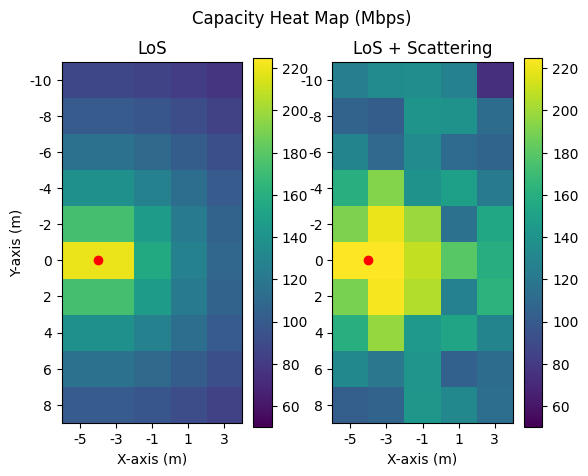

In [16]:
#Plot the capacity 
plt.figure();

# Create a 2D color bar plot
plt.subplot(1,2,1)
plt.imshow(1e-6*capacity_vector_no_env.reshape(y.shape[0],x.shape[0]), cmap='viridis')  # 'viridis' is just an example colormap, you can choose any colormap you like
plt.colorbar()  # Add a color bar

plt.plot(Tx_location[0]/cell_size + x.size/2,Tx_location[1]/cell_size + y.size/2,'ro')
plt.xlabel('X-axis (m)')
plt.ylabel('Y-axis (m)')
plt.title('LoS')

plt.xticks(range(x.size),x)
plt.yticks(range(y.size),y)
plt.clim(50,225)

plt.subplot(1,2,2)
plt.imshow(1e-6*capacity_vector_with_env.reshape(y.shape[0],x.shape[0]), cmap='viridis')  # 'viridis' is just an example colormap, you can choose any colormap you like
plt.colorbar()  # Add a color bar

plt.plot(Tx_location[0]/cell_size + x.size/2,Tx_location[1]/cell_size + y.size/2,'ro')
plt.xlabel('X-axis (m)')
plt.title('LoS + Scattering')

plt.xticks(range(x.size),x)
plt.yticks(range(y.size),y)

plt.clim(50,225)
plt.suptitle('Capacity Heat Map (Mbps)')
plt.show()

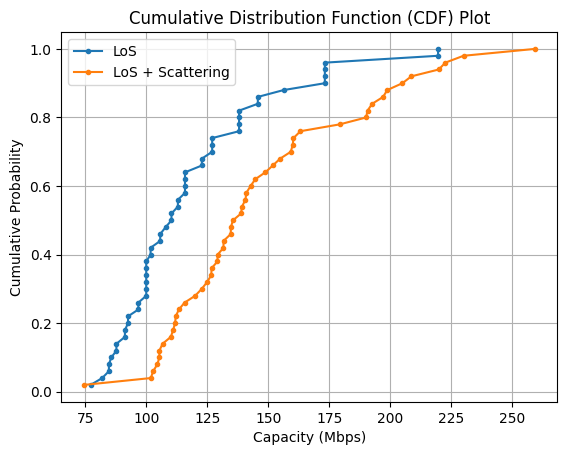

In [17]:
# Statistics of capacity
plt.figure();

# Sort the data
sorted_data1 = np.sort(capacity_vector_no_env*1e-6)
sorted_data2 = np.sort(capacity_vector_with_env*1e-6)

# Calculate the CDF
cdf1 = np.arange(1, len(sorted_data1) + 1) / len(sorted_data1)
cdf2 = np.arange(1, len(sorted_data2) + 1) / len(sorted_data2)

# Plot the CDFs
plt.plot(sorted_data1, cdf1, marker='.', linestyle='-', label='LoS')
plt.plot(sorted_data2, cdf2, marker='.', linestyle='-', label='LoS + Scattering')

# Add labels and title
plt.xlabel('Capacity (Mbps)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF) Plot')
plt.legend()  # Show legend
plt.grid(True)
plt.show()